In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [2]:
# time discrete state-space model
# x_k+1 = A * x_k

A = np.array([[ 0.996,  0.05 ,  0.001,  0.   ],
              [-0.15 ,  0.996,  0.05 ,  0.001],
              [ 0.008,  0.   ,  0.992,  0.05 ],
              [ 0.332,  0.008, -0.332,  0.992]])

def rhs(xk0):
    ''' 
    right hand side of time discrete state space
    input: xk+0 dim=1d
    return: xk+1 dim=2d(1,4)
    '''
    xk0_v = np.expand_dims(xk0, axis=1)
    xk1 = A @ xk0_v
    return xk1.T

In [3]:
def run_rhs(ics, steps):
    '''
    function to run model with
    ics : initial contitions
    steps : number of steps
    return : time series from x_0 to x_steps+1
    '''
    xkn = np.expand_dims(ics, 0)
    for i in range(steps):
        xkn = np.concatenate((xkn, rhs(xkn[-1])), axis=0)
    return xkn

In [4]:
# create random intital conditions between -2 and 2
ics_number = 64  # how many random initial conditions to create
rand_ics = np.random.rand(ics_number, 4) * 4 - 2
# number of steps
n_steps = 100
# 
res = [run_rhs(ics, n_steps) for ics in rand_ics]

In [5]:
# list of sets containing time series [observed, hidden, observed_next_step] as torch.tensor
data_torch = [[torch.from_numpy(res_set[:-1, [0, 1]]).float(),
               torch.from_numpy(res_set[:-1, [2, 3]]).float(),
               torch.from_numpy(res_set[1:, [0, 1]]).float()] for res_set in res]

# split in train an test data (not really necessary in this case)
train_data = data_torch[:ics_number - 10]
test_data = data_torch[ics_number - 10:]

In [6]:
# define neural network
class model_c(nn.Module):
    '''
    model to directly approximate A as one layer with four neurons, no activation function and no bias 
    '''
    
    def __init__(self):
        
        super().__init__()

        self.A_net = nn.Linear(4, 4, bias=False)
        
    def forward(self, x_observed, x_hidden):
        x = torch.cat((x_observed, x_hidden), 1)
        
        Ax = self.A_net(x)
        
        x_observed_out, x_hidden_out =torch.split(Ax, [2, 2], 1)
        return x_observed_out, x_hidden_out

In [8]:
model = model_c()
# store weights for comparison
A_net_before = torch.detach(model.A_net.weight.data.clone())

In [9]:
# set loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00003)
loss_list = []

In [22]:
# train the network
epochs = 10
printevery = 1

for epoch in range(epochs):
    
    # Running each batch separately 
    
    for bat in train_data:
        
        h1 = bat[1][[0]]  # intialise hidden variable with initial conditions for x3, x4 at step 0
    
        for i in range(len(bat[0])):
            inputs = bat[0][[i]]  # x1, x2 at time step k
            labels = bat[2][[i]]  # x1, x2 at time step k+1
            
            # set the optimization gradient to zero
            optimizer.zero_grad()
            # Make predictions with x1, x2 from data and x3, x4 from previous step
            out, h1 = model(inputs, h1)
            # Compute the loss for x1, x2
            loss = criterion(out, labels)
            # Perform back propogation and gradient descent
            loss.backward()
            optimizer.step()
            
            h1 = torch.detach(h1)  # detatch gradient or else I get an error
            
        loss_list.append(loss.item())
    if epoch%printevery == 0:
        print(f'Epoch: {epoch} Loss: {loss.item():10.8f}')


print('finished')

Epoch: 0 Loss: 0.00270656
Epoch: 1 Loss: 0.00267010
Epoch: 2 Loss: 0.00263240
Epoch: 3 Loss: 0.00259481
Epoch: 4 Loss: 0.00255775
Epoch: 5 Loss: 0.00252128
Epoch: 6 Loss: 0.00248549
Epoch: 7 Loss: 0.00245035
Epoch: 8 Loss: 0.00241584
Epoch: 9 Loss: 0.00238204
finished


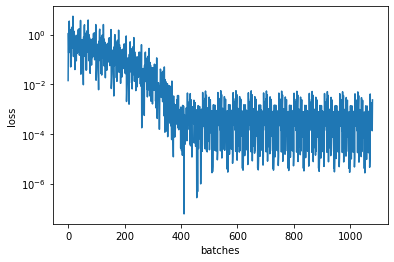

In [23]:
# plot loss over batches run
plt.plot(loss_list)
plt.yscale('log')
plt.xlabel('batches')
plt.ylabel('loss')
plt.show()

In [24]:
# display network weights before and after training
# lst two rows are not effected
print(f'before: {A_net_before}\nafter:  {model.A_net.weight.data}')

before: tensor([[ 1.0547,  0.1897,  0.2297,  0.3243],
        [-0.2347,  0.7862,  0.0655, -0.3720],
        [ 0.0345, -0.0467,  0.1113, -0.3463],
        [-0.2485, -0.4938,  0.3814,  0.1939]])
after: tensor([[ 1.0320,  0.1384,  0.1577,  0.2080],
        [-0.1934,  0.8519,  0.0208, -0.2598],
        [ 0.0345, -0.0467,  0.1113, -0.3463],
        [-0.2485, -0.4938,  0.3814,  0.1939]])


In [14]:
# test trained network by using it to predict time series (n_steps into the futer)
# with only the initial conditions for all variables
model.eval()
bat = test_data[5]

with torch.no_grad():
    inputs = bat[0][[0]]
    h1 = bat[1][[0]]
    
    for i in range(len(bat[0])):
        out, h1_out = model(inputs[[-1]], h1[[-1]])
        inputs = torch.cat((inputs, out), 0)
        h1 = torch.cat((h1, h1_out), 0)

<ipython-input-15-a0197c86b119>:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


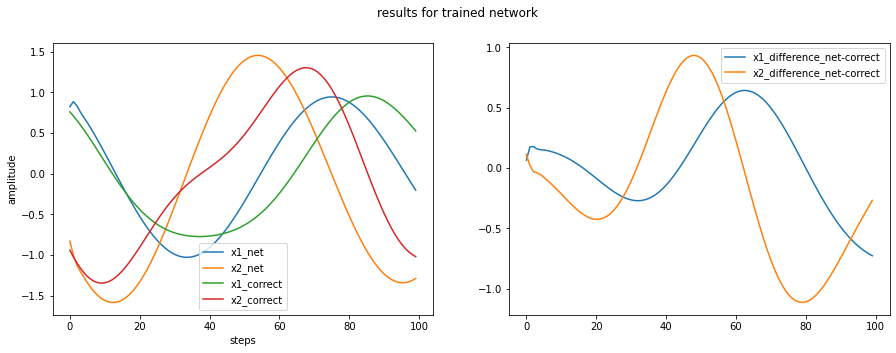

In [15]:
# results from original state-space and trained network 
fig = plt.figure(figsize=(15, 5))
fig.suptitle('results for trained network')
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(inputs[1:, 0], label='x1_net')
ax1.plot(inputs[1:, 1], label='x2_net')
ax1.plot(bat[2][:, 0], label='x1_correct')
ax1.plot(bat[2][:, 1], label='x2_correct')
ax1.set(xlabel='steps', ylabel='amplitude')
ax2.plot(inputs[1:, 0] - bat[2][:, 0], label='x1_difference_net-correct')
ax2.plot(inputs[1:, 1] - bat[2][:, 1], label='x2_difference_net-correct')
ax1.legend()
ax2.legend()
fig.show()

In [16]:
# set weights of network manuealy to equal A
model_ideal = model_c()
model_ideal.A_net.weight.data = torch.from_numpy(A).float()

In [17]:
# test ideal network by using it to predict time series (n_steps into the futer)
# with only the initial conditions for all variables
model_ideal.eval()
bat = test_data[5]

with torch.no_grad():
    inputs = bat[0][[0]]
    h1 = bat[1][[0]]
    
    for i in range(len(bat[0])):
        out, h1_out = model_ideal(inputs[[-1]], h1[[-1]])
        inputs = torch.cat((inputs, out), 0)
        h1 = torch.cat((h1, h1_out), 0)

<ipython-input-18-a5548a561b5d>:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


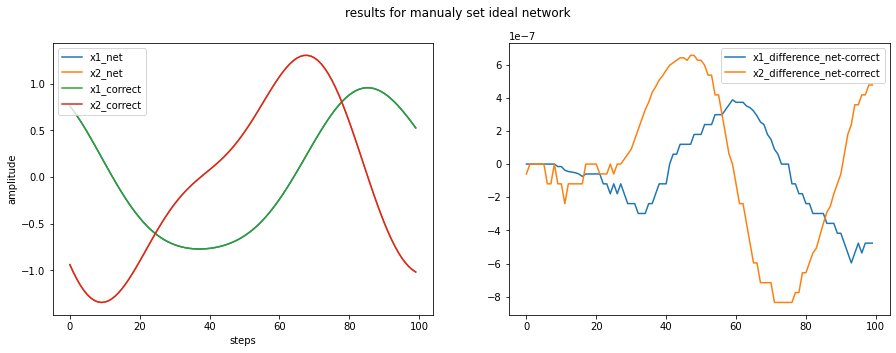

In [18]:
# results from original state-space and ideal network are identical
fig = plt.figure(figsize=(15, 5))
fig.suptitle('results for manualy set ideal network')
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(inputs[1:, 0], label='x1_net')
ax1.plot(inputs[1:, 1], label='x2_net')
ax1.plot(bat[2][:, 0], label='x1_correct')
ax1.plot(bat[2][:, 1], label='x2_correct')
ax1.set(xlabel='steps', ylabel='amplitude')
ax2.plot(inputs[1:, 0] - bat[2][:, 0], label='x1_difference_net-correct')
ax2.plot(inputs[1:, 1] - bat[2][:, 1], label='x2_difference_net-correct')
ax1.legend()
ax2.legend()
fig.show()